## Purpose
  1. Decision Tree 실습 및 해석
  2. Variance를 낮추기위한 Bagging의 대표적인 모델 RandomForest 실습 및 해석

In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from collections import Counter
from sklearn import tree

In [2]:
# Data Loading - 수술 시 사망 데이터
data = pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
0,0,1090,43,66.679,0,1,0,100,0,1,...,1,1,3,0,504,353,660,1,870,782
1,1,794,31,73.030,0,1,0,100,0,1,...,1,1,3,0,244,225,106,1,708,699
2,0,957,41,66.226,0,1,1,100,0,1,...,1,1,3,0,401,366,453,1,889,720
3,1,188,35,78.019,0,1,0,100,0,1,...,1,1,3,0,221,132,-1,0,221,759
4,1,308,40,83.009,0,1,0,100,0,1,...,1,1,3,1,150,90,20,1,1730,1160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0,1097,24,71.000,1,0,0,100,0,1,...,1,1,2,0,364,475,734,1,770,802
528,1,154,21,52.300,1,0,0,90,0,1,...,1,1,2,0,415,181,84,1,949,666
529,1,588,16,63.000,1,0,0,100,0,1,...,1,1,3,0,299,214,124,1,546,471
530,0,395,17,102.967,1,0,0,100,0,1,...,1,1,3,0,373,218,-1,0,1759,1030


In [6]:
print(f'rows : {data.shape[0]}')
print(f'columns : {data.shape[1]}')

rows : 532
columns : 23


In [7]:
data.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


## ISSUE
 - Tree 계열은 Scaling이 필요한가? No!

In [8]:
# Data balance check
Counter(data['censor'])

# Imbalance 존재 -> ACC가 아닌 F1-score을 써야함

Counter({0: 351, 1: 181})

In [9]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [10]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2023)
print(f"# of Train data : {len(train_idx)}")
print(f"# of valid data : {len(valid_idx)}")
print(f"# of Train data Y : {Counter(Y.iloc[train_idx])}")
print(f"# of valid data Y : {Counter(Y.iloc[valid_idx])}")

# of Train data : 372
# of valid data : 160
# of Train data Y : Counter({0: 250, 1: 122})
# of valid data Y : Counter({0: 101, 1: 59})


## Decision Tree를 활용한 Rule Extraction

 - Max_Depth는 5 초과를 넘지 않아야함
  - 5를 초과하게 되면 Rule Extraction Plotting의 가독성이 매우 떨어짐
 - 정확도와 설명력은 Trade-off가 존재하기 때문에 자기만의 기준으로 적절한 선을 선택하면 됨
 - Rule Extraction 할 때 GINI INDEX 뿐만 아니라 Sample 개수도 중요한 척도가 됨

  - GINI INDEX가 아주 낮지만(불순도가 낮음, 좋음) Sample의 개수가 너무 적으면 의미가 없음(Overfitting이라고 생각됨)

In [11]:
# Depth 조절 Decision Tree
for i in range(2,11,1):
    print(f"Depth {i}")

    model = DecisionTreeClassifier(max_depth=i, criterion='gini')
    model.fit(X.iloc[train_idx], Y.iloc[train_idx])

    # Train Acc
    y_pre_train = model.predict(X.iloc[train_idx])
    cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
    print("Train Confusion Matrix")
    print(cm_train)
    print(f"Train Acc : {(cm_train[0,0] + cm_train[1,1])/cm_train.sum()}")
    print(f"Train F1-Score : {f1_score(Y.iloc[train_idx], y_pre_train)}")

    # Test Acc
    y_pre_test = model.predict(X.iloc[valid_idx])
    cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
    print("Train Confusion Matrix")
    print(cm_test)
    print(f"TesT Acc : {(cm_test[0,0] + cm_test[1,1])/cm_test.sum()}")
    print(f"Test F1-Score : {f1_score(Y.iloc[valid_idx], y_pre_test)}")
    print("-----------------------------------------------------------------------")
    print("-----------------------------------------------------------------------")

    # Depth가 4일 때 가장 F1 score가 높음 -> 4 선

Depth 2
Train Confusion Matrix
[[241   9]
 [ 44  78]]
Train Acc : 0.8575268817204301
Train F1-Score : 0.7464114832535885
Train Confusion Matrix
[[97  4]
 [26 33]]
TesT Acc : 0.8125
Test F1-Score : 0.6874999999999999
-----------------------------------------------------------------------
-----------------------------------------------------------------------
Depth 3
Train Confusion Matrix
[[228  22]
 [ 18 104]]
Train Acc : 0.8924731182795699
Train F1-Score : 0.8387096774193549
Train Confusion Matrix
[[87 14]
 [13 46]]
TesT Acc : 0.83125
Test F1-Score : 0.773109243697479
-----------------------------------------------------------------------
-----------------------------------------------------------------------
Depth 4
Train Confusion Matrix
[[227  23]
 [ 10 112]]
Train Acc : 0.9112903225806451
Train F1-Score : 0.8715953307392996
Train Confusion Matrix
[[89 12]
 [11 48]]
TesT Acc : 0.85625
Test F1-Score : 0.8067226890756303
---------------------------------------------------------------

In [12]:
model = DecisionTreeClassifier(max_depth=4, criterion='gini')
model.fit(X.iloc[train_idx], Y.iloc[train_idx])

DecisionTreeClassifier(max_depth=4)

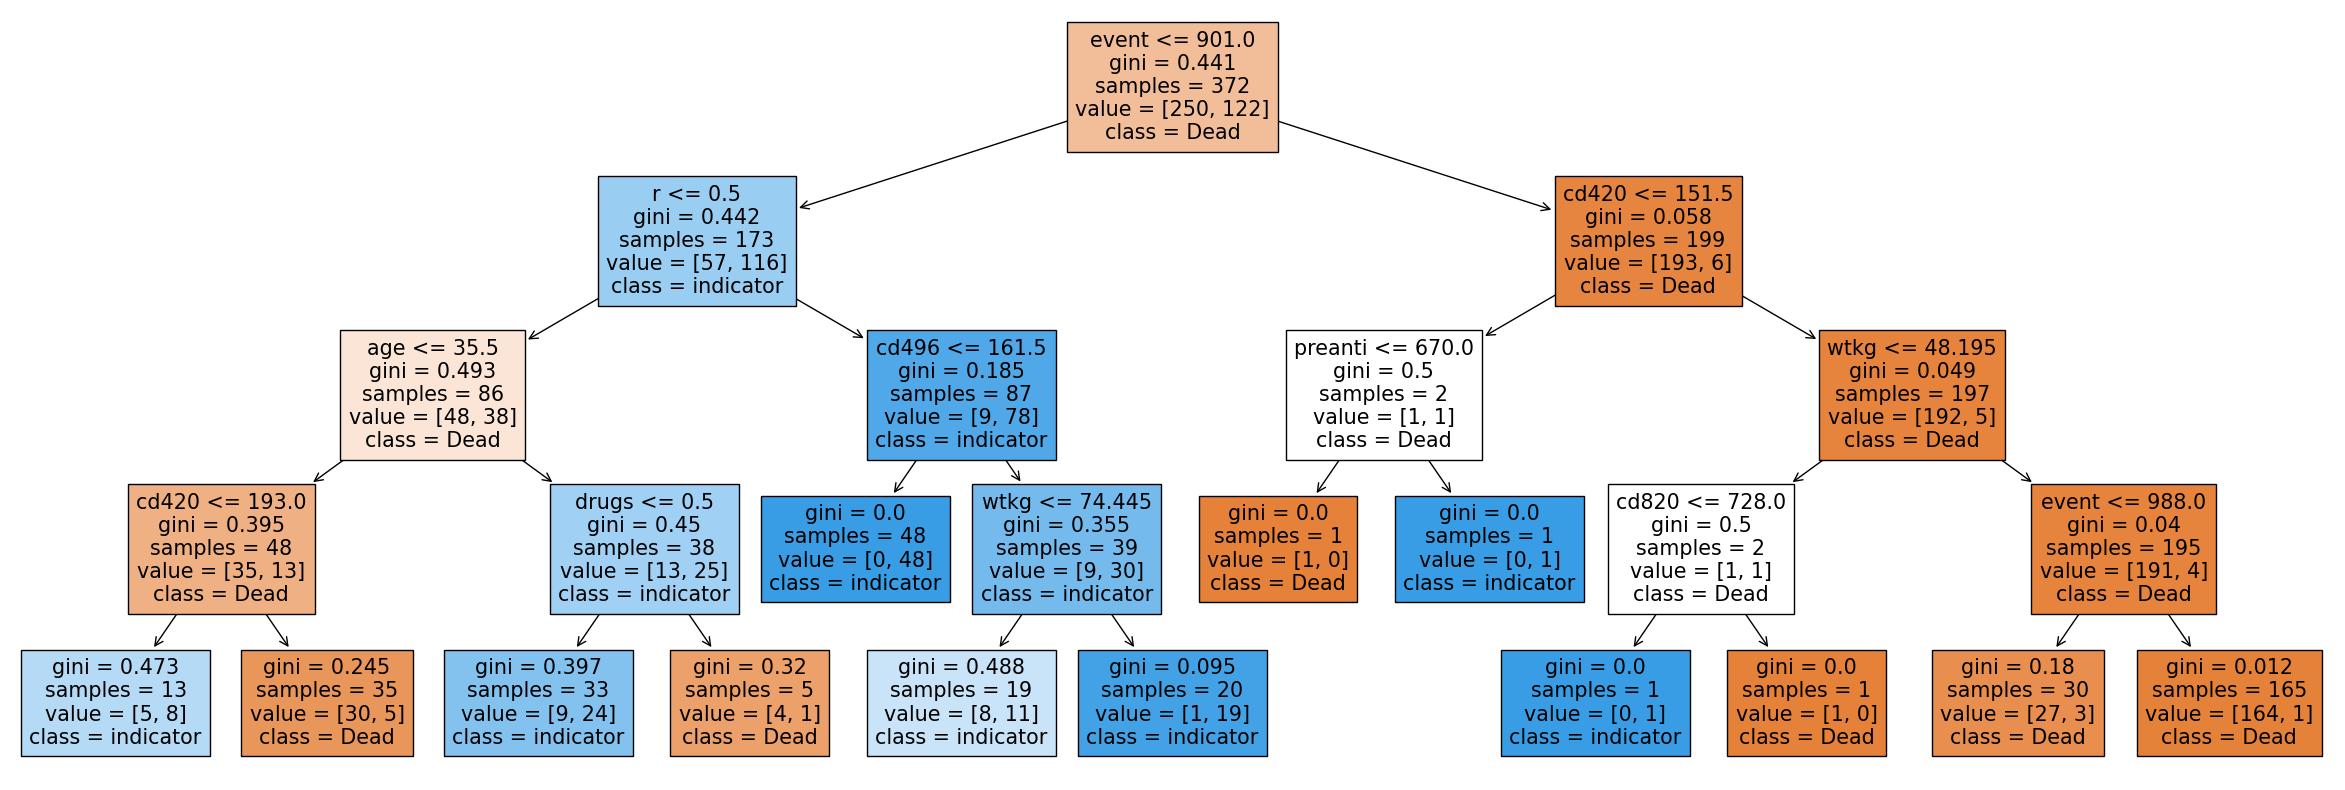

In [16]:
# Creating the tree plot
tree.plot_tree(model, filled=True, feature_names=X.columns, class_names = ['Dead', 'indicator'])
plt.rcParams['figure.figsize'] = [30,20]

## Random Forest

 - Hyperparameter tuning
 - estimators, depth
  - Random Forest는 이 두개만 조절해도 좋은 결과를 얻을 수 있음
 - GridSearchCV를 사용하지 않고 For Loop를 돌리는 이유
    - 내가 원하는 결과를 저장하고 Display 하고 싶음
    - 내가 원하는 결과를 실시간 Display 하면서 그때 그때 파라미터 튜닝에 대한 대처를 하고 싶음

## Random Forest Parameters
  - Package : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
  - n_estimators : # of Tree
  - criterion : Measuring for Split (Information gain)
     - Gini
     - entropy
     - log_loss
  - max_depth : Tree의 최대 깊이 제한
  - min_samples_split : 2개로 Split 하는게 아니라 N개로 Split 가능
  - bootstrap : Bagging 중 Boostrap 기법
  - max_features : Feature 수 sampling
     - auto
     - sqrt
     - log2
  - oob_score : out-of-bag Score
  - class_weight : Label Imbalance 데이터 학습시 weight를 주는 것
     - {0: 1, 1: 1}
  - random_state : Two way Random Choosen 때문에 매 결과가 달라짐
     - 지정한 값으로 해주는 것이 결과가 같아짐

In [18]:
# RandomForest Hyperparameter
estimators = [10, 30, 40, 50, 60]
depth = [4 , 5, 10, 15]

# Modeling
save_est = []
save_dep = []
f1_score_ = []

cnt = 0
for est in estimators:
    for dep in depth:
        print(f"cnt : {cnt}")
        cnt += 1
        print(f"Number of Estimators : {est}, Max Depth : {dep}")

        model = RandomForestClassifier(n_estimators=est, max_depth=dep, random_state=119,
                                       criterion='gini', max_features='auto',
                                       bootstrap=True, oob_score=False) # if you use "oob_score=True", get long time for training
        model.fit(X.iloc[train_idx], Y.iloc[train_idx])

        # Train Acc
        y_pre_train = model.predict(X.iloc[train_idx])
        cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
        print("Train Confusion Matrix")
        print(cm_train)
        print(f"Train Acc : {(cm_train[0,0] + cm_train[1,1])/cm_train.sum()}")
        print(f"Train F1-Score : {f1_score(Y.iloc[train_idx], y_pre_train)}")

        # Test Acc
        y_pre_test = model.predict(X.iloc[valid_idx])
        cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
        print("Test Confusion Matrix")
        print(cm_test)
        print(f"TesT Acc : {(cm_test[0,0] + cm_test[1,1])/cm_test.sum()}")
        print(f"Test F1-Score : {f1_score(Y.iloc[valid_idx], y_pre_test)}")
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")
        save_est.append(est)
        save_dep.append(dep)
        f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))

cnt : 0
Number of Estimators : 10, Max Depth : 4
Train Confusion Matrix
[[242   8]
 [ 29  93]]
Train Acc : 0.9005376344086021
Train F1-Score : 0.8340807174887892
Test Confusion Matrix
[[93  8]
 [26 33]]
TesT Acc : 0.7875
Test F1-Score : 0.6599999999999999
-----------------------------------------------------------------------
-----------------------------------------------------------------------
cnt : 1
Number of Estimators : 10, Max Depth : 5
Train Confusion Matrix
[[243   7]
 [ 14 108]]
Train Acc : 0.9435483870967742
Train F1-Score : 0.9113924050632911
Test Confusion Matrix
[[90 11]
 [23 36]]
TesT Acc : 0.7875
Test F1-Score : 0.679245283018868
-----------------------------------------------------------------------
-----------------------------------------------------------------------
cnt : 2
Number of Estimators : 10, Max Depth : 10
Train Confusion Matrix
[[249   1]
 [  3 119]]
Train Acc : 0.989247311827957
Train F1-Score : 0.9834710743801653
Test Confusion Matrix
[[93  8]
 [23 36]

In [19]:
# Best Model
best_model = RandomForestClassifier(n_estimators=save_est[np.argmax(f1_score_)], max_depth=save_dep[np.argmax(f1_score_)], random_state=119,
                               criterion='gini', max_features='auto',
                               bootstrap=True, oob_score=False) # if you use "oob_score=True", get long time for training
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=40,
                       random_state=119)

In [20]:
# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print(f"Train Acc : {(cm_train[0,0] + cm_train[1,1])/cm_train.sum()}")
print(f"Train F1-Score : {f1_score(Y.iloc[train_idx], y_pre_train)}")

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print(f"TesT Acc : {(cm_test[0,0] + cm_test[1,1])/cm_test.sum()}")
print(f"Test F1-Score : {f1_score(Y.iloc[valid_idx], y_pre_test)}")

Train Confusion Matrix
[[250   0]
 [  0 122]]
Train Acc : 1.0
Train F1-Score : 1.0
Test Confusion Matrix
[[93  8]
 [12 47]]
TesT Acc : 0.875
Test F1-Score : 0.8245614035087718


In [21]:
# Featrue Importance Score
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.325071    event
1   0.116611    cd420
2   0.080297    cd496
3   0.068333     cd80
4   0.066404     wtkg
5   0.064655    cd820
6   0.062691     cd40
7   0.054047      age
8   0.047875  preanti
9   0.036185        r
10  0.013194   karnof
11  0.011671    strat
12  0.011409     race
13  0.006760    drugs
14  0.006678   gender
15  0.006291     hemo
16  0.006121     homo
17  0.005438  symptom
18  0.005390      z30
19  0.004878     str2
20  0.000000   zprior
21  0.000000   oprior


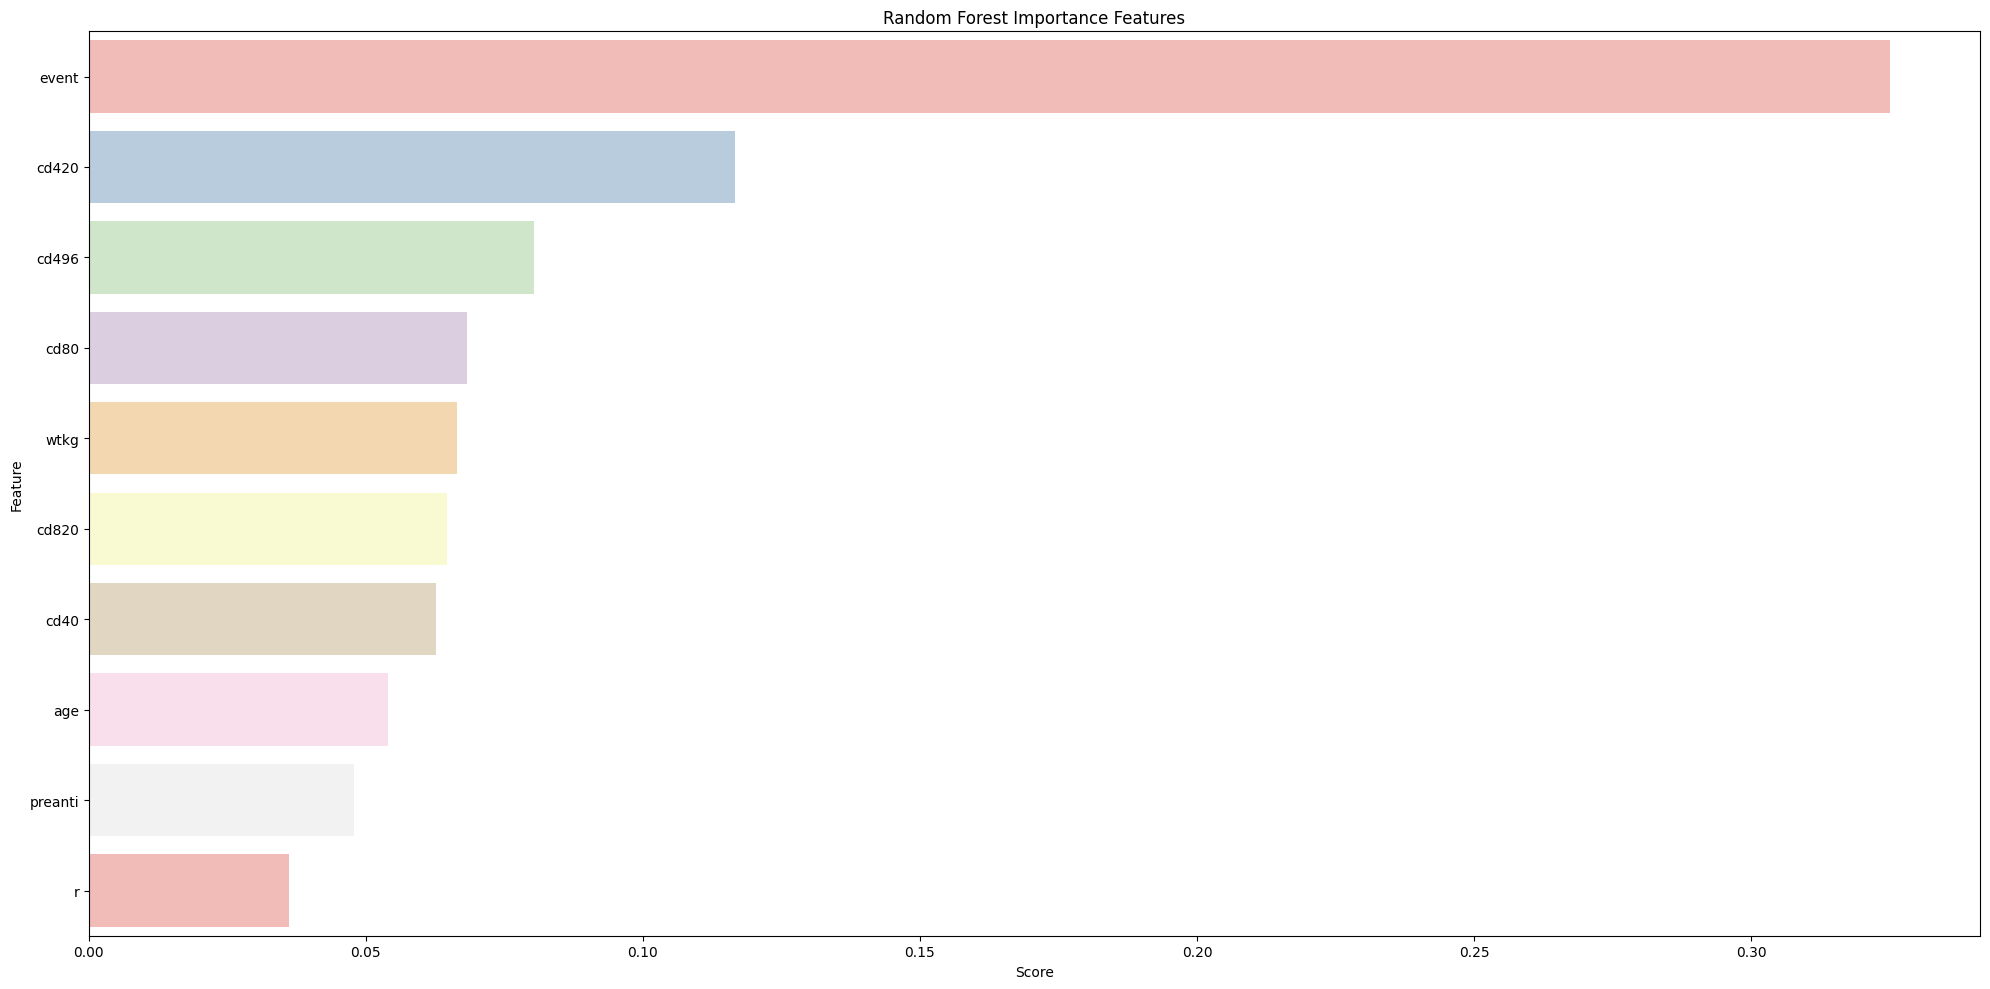

In [23]:
# Importance Score Top 10
feature_map_20 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_20.sort_values(by="Score", ascending=False), errwidth=40, palette='Pastel1')
plt.title('Random Forest Importance Features')
plt.tight_layout()
plt.show()